<a href="https://colab.research.google.com/github/GarryNeKasparov/Digit-Recognizer/blob/main/Square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [9]:
batch_size_train = 64
batch_size_test = 1000
random_seed = 1

In [10]:
Transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

In [11]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True,
                             transform=Transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=False, download=True,
                             transform=Transform),
  batch_size=batch_size_test, shuffle=True)

In [13]:
mnist_valset, test_loader = torch.utils.data.random_split(test_loader, [int(0.9 *    len(test_loader)), int(0.1 * len(test_loader))])

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_loader, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_loader, batch_size=32, shuffle=False)

In [15]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

TypeError: ignored

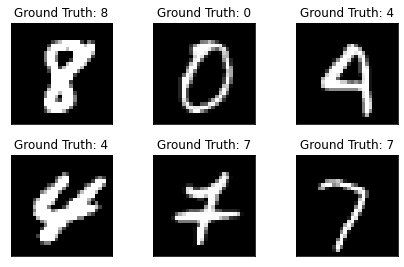

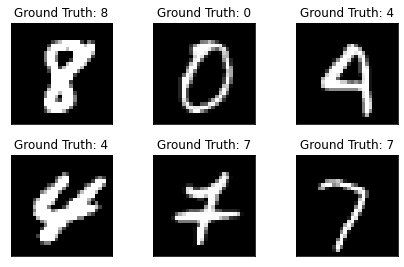

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [16]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.maxPolling = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
    self.linear2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxPolling(x)
    x = x.reshape(x.size(0), -1)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.dropout(x)

    pred = self.linear2(x)

    return pred
        

In [22]:
model = Model()
model.cuda()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPolling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
model

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPolling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
torch.cuda.is_available()

True

In [20]:
total = 0

In [30]:
n_epochs = 100
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(n_epochs):
  total_train_loss = 0
  total_val_loss = 0

  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.cuda()
    target = target.cuda()

    pred = model(data)
    loss = criterion(pred, target)
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()
  total_train_loss = total_train_loss /  (batch_idx + 1)
  train_loss.append(total_train_loss)

  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda()
    target = target.cuda()
    pred = model(data)
    loss = criterion(pred, target)
    total_val_loss += loss.item()
    pred = F.softmax(pred, dim=1)

    for i, p in enumerate(pred):
      if (target[i] == torch.max(p.data, 0)[1]):
        total += 1
    accuracy = total / len(mnist_valset)
  total_val_loss = total_val_loss / (batch_idx + 1)
  val_loss.append(total_val_loss)

  print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, n_epochs, total_train_loss, total_val_loss, accuracy))

  if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()        


Epoch: 1/100, Train Loss: 2.30562896, Val Loss: 2.30475314, Val Accuracy: 7499.55555556

Epoch: 2/100, Train Loss: 2.30578520, Val Loss: 2.30476547, Val Accuracy: 8195.66666667

Epoch: 3/100, Train Loss: 2.30573329, Val Loss: 2.30476566, Val Accuracy: 8891.77777778

Epoch: 4/100, Train Loss: 2.30609580, Val Loss: 2.30476254, Val Accuracy: 9587.88888889

Epoch: 5/100, Train Loss: 2.30588835, Val Loss: 2.30475522, Val Accuracy: 10284.00000000

Epoch: 6/100, Train Loss: 2.30602914, Val Loss: 2.30475678, Val Accuracy: 10980.11111111

Epoch: 7/100, Train Loss: 2.30600074, Val Loss: 2.30476355, Val Accuracy: 11676.22222222


KeyboardInterrupt: ignored